### Steps: 
- Load the EEG data.
- Apply the artifact rejection to clean the data.
- Visualize the cleaned EEG data.
- LogisticRegression model

Creating RawArray with float64 data, n_channels=8, n_times=60871
    Range : 0 ... 60870 =      0.000 ...   243.480 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Creating RawArray with float64 data, n_channels=8, n_times=60282
    Range : 0 ... 60281 =      0.000 ...   241.124 secs
Ready.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


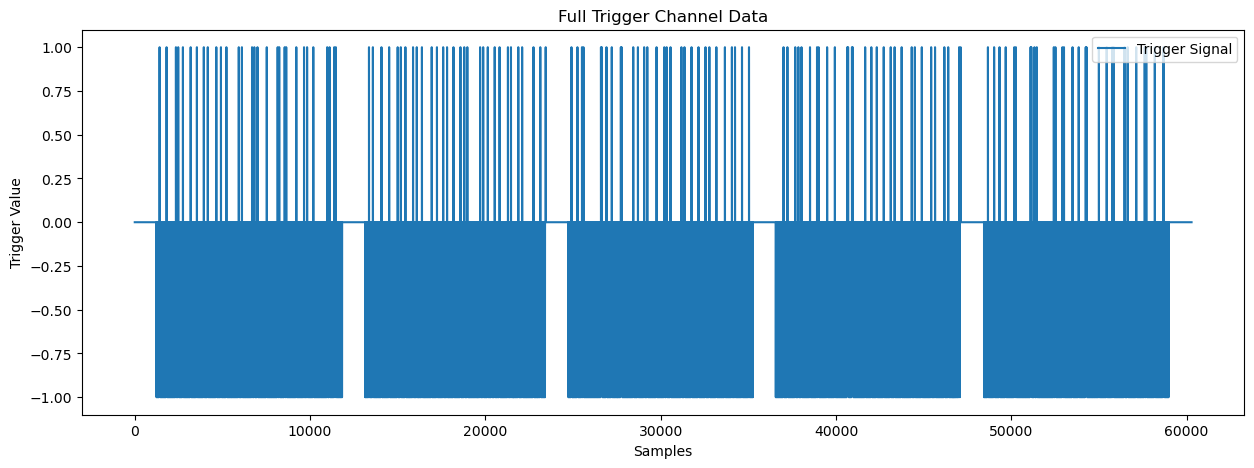

Using qt as 2D backend.
Not setting metadata
1195 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1195 events and 176 original time points ...
0 bad epochs dropped
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\Tomar\AppData\Local\Temp\ipykernel_12116\2892723059.py:68: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  psd_fig = cleaned_raw.plot_psd(average=True, show=True)
c:\Users\Tomar\miniconda3\envs\py311\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


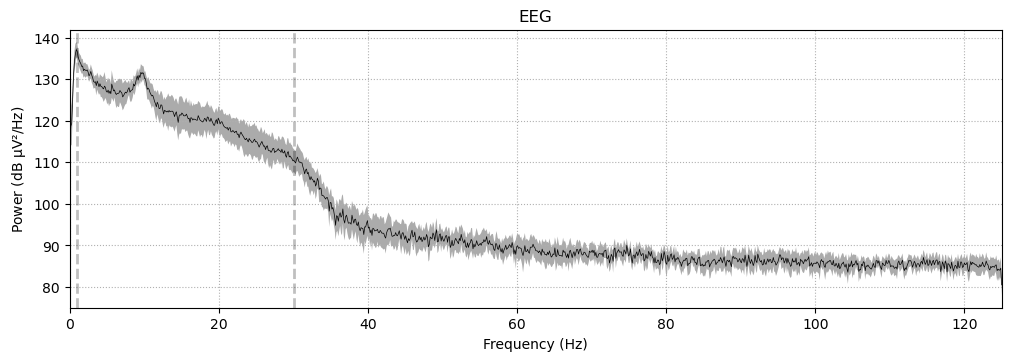

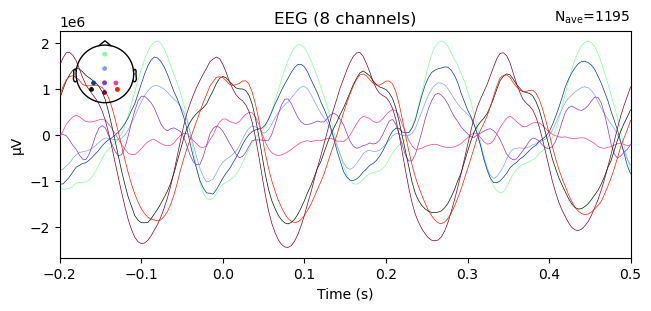

Channels marked as bad:
none


In [1]:
import numpy as np
import scipy.io as sio
import mne
import matplotlib.pyplot as plt

# Define functions for loading data, preprocessing, and artifact rejection
def load_data(file_path):
    mat_data = sio.loadmat(file_path)
    fs = mat_data['fs'][0, 0]  # Sampling frequency
    y = mat_data['y']  # EEG data
    trig = mat_data['trig'][:, 0]  # Ensure trig is 1D
    return y, trig, fs

def preprocess_eeg_data(y, trig, fs):
    ch_names = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'Oz', 'PO8']
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)
    info.set_montage('standard_1020')
    
    raw = mne.io.RawArray(y.T, info)
    raw.filter(1., 30., fir_design='firwin')
    return raw, trig

def reject_artifacts(raw, trig, threshold=3.0):
    data = raw.get_data()
    stds = np.std(data, axis=0)
    mean_std = np.mean(stds)
    valid_indices = stds < mean_std * threshold
    
    cleaned_data = data[:, valid_indices]
    cleaned_trig = trig[valid_indices]
    cleaned_raw = mne.io.RawArray(cleaned_data, raw.info)
    return cleaned_raw, cleaned_trig

def plot_full_trigger_data(trig):
    plt.figure(figsize=(15, 5))
    plt.plot(trig, label='Trigger Signal')
    plt.title('Full Trigger Channel Data')
    plt.xlabel('Samples')
    plt.ylabel('Trigger Value')
    plt.legend()
    plt.show()

# Load and preprocess the data
file_path = './p300/S1.mat'
y, trig, fs = load_data(file_path)
raw, trig = preprocess_eeg_data(y, trig, fs)
cleaned_raw, cleaned_trig = reject_artifacts(raw, trig)

# Plot full trigger data to understand its behavior
plot_full_trigger_data(cleaned_trig)

# Visualizing the cleaned EEG data
fig = cleaned_raw.plot(scalings='auto', title='Cleaned EEG Data', show=True)

# Manually create events array from the cleaned triggers
event_times = np.where(np.diff(cleaned_trig) != 0)[0] + 1  # Find changes in trigger values
event_values = cleaned_trig[event_times]  # Get the trigger values at these times
events = np.column_stack((event_times, np.zeros_like(event_times), event_values))

# Define event IDs
event_id = {'non-target': -1, 'target': 1}

# Create epochs for ERP analysis
epochs = mne.Epochs(cleaned_raw, events, event_id=event_id, tmin=-0.2, tmax=0.5, baseline=(None, 0), preload=True)

# Plot the Power Spectral Density and ERP components
psd_fig = cleaned_raw.plot_psd(average=True, show=True)
erp_fig = epochs.average().plot(spatial_colors=True, show=True)


In [3]:
# Extract indices for targets and non-targets from previously cleaned trigger data
targets = np.where(cleaned_trig == 1)[0]
non_targets = np.where(cleaned_trig == -1)[0]

# Parameters for splits
n_splits = 20
test_size_targets = 10
test_size_non_targets = 70

# Storing indices of training and testing
splits = []

for _ in range(n_splits):
    # Shuffle the indices for randomness
    np.random.shuffle(targets)
    np.random.shuffle(non_targets)
    
    # Select test indices
    test_indices = np.concatenate((targets[:test_size_targets], non_targets[:test_size_non_targets]))
    train_indices = np.concatenate((targets[test_size_targets:], non_targets[test_size_non_targets:]))
    
    # Append to list
    splits.append((train_indices, test_indices))

# Output the indices for the first split as an example
splits[0]


(array([22097,  7000, 51452, ...,  7087, 32067, 19960], dtype=int64),
 array([44319, 40644, 53844, 55840, 20138, 54995, 48666, 18796, 17593,
         3545, 14423, 39539, 32201, 56725, 52161, 56768,  2701, 45471,
        16982, 36788, 46002, 19267,  9964, 50744, 30915, 28392, 52252,
         4342,  9785, 37275, 54773, 48489, 34196, 57166, 30118, 51542,
        37896, 36742, 50392, 44850, 53624, 14245, 57213, 37807, 14290,
        31669,  9614,  6024, 22141, 49153, 48974, 39805, 28215, 21199,
        28924, 33973, 31979, 20271, 31623, 34593, 41310, 14202, 19489,
        38607, 41397, 32332,  7310, 17415,  3323, 26332, 44761, 15831,
        50305, 38066,  6777, 22655, 58406, 32113,  8284, 48842],
       dtype=int64))

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Reassessing the structure of the EEG data array to properly extract the samples
X_all = cleaned_raw.get_data().T  # Transposing to get correct orientation (samples x channels)

# Validate dimensions and data extraction process
n_samples, n_channels = X_all.shape

# Initialize lists to store metrics again
accuracies = []
classification_reports = []

# Loop through each split
for train_indices, test_indices in splits:
    # Ensure indices are within the range
    train_indices = [idx for idx in train_indices if idx < n_samples]
    test_indices = [idx for idx in test_indices if idx < n_samples]

    # Extract training and testing data
    X_train = X_all[train_indices, :]
    y_train = cleaned_trig[train_indices]
    X_test = X_all[test_indices, :]
    y_test = cleaned_trig[test_indices]
    
    # Define the model
    model = LogisticRegression(max_iter=1000, solver='liblinear')  # Using liblinear for binary classification
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test data
    predictions = model.predict(X_test)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, predictions)
    accuracies.append(acc)
    
    # Generate a classification report
    report = classification_report(y_test, predictions, output_dict=True)
    classification_reports.append(report)

# Output average accuracy
average_accuracy = np.mean(accuracies)
average_accuracy


c:\Users\Tomar\miniconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tomar\miniconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tomar\miniconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

0.875